In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())

In [32]:
# 전체 출력 설정
pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력

In [371]:
df_2021 = pd.read_csv('data/konex_suv_2021.csv')
df_2022 = pd.read_csv('data/konex_suv_2022.csv')
df_2023 = pd.read_csv('data/konex_suv_2023.csv')
df = pd.read_csv('data/konex_final_with_cat.csv')
print(df_2021.shape, df_2022.shape, df_2023.shape, df.shape)

(189, 87) (189, 87) (189, 87) (189, 326)


### 데이터 핸들링

In [372]:
# 생존 여부 칼럼 추가 -> 0이면 생존, 1이면 사망(폐지)
def data_handling(df):
    df['유지기간'] = df['유지기간'].str.replace(' days', '').astype(int)
    df['상장일'] = pd.to_datetime(df['상장일'])
    df['코넥스폐지일자'] = pd.to_datetime(df['코넥스폐지일자'])
    df['suv'] = np.where(df['코넥스폐지일자'].isnull(), 0, 1)
    df.drop(columns=['코넥스비고'], inplace = True)

    # 특성 이름에서 허용되지 않는 문자 제거
    df.columns = df.columns.str.replace(r'[\[\]{}()."]', '_', regex=True)
    return df

def data_handling_2(df):
    df['상장일'] = pd.to_datetime(df['상장일'])
    df['코넥스폐지일자'] = pd.to_datetime(df['코넥스폐지일자'])
    df['suv'] = np.where(df['코넥스폐지일자'].isnull(), 0, 1)
    df.drop(columns=['코넥스폐지사유'], inplace = True)
    df.drop(columns=['코넥스비고'], inplace = True)

    # 특성 이름에서 허용되지 않는 문자 제거
    df.columns = df.columns.str.replace(r'[\[\]{}()."]', '_', regex=True)
    return df

df = data_handling(df)
df_2021 = data_handling_2(df_2021)
df_2022 = data_handling_2(df_2022)
df_2023 = data_handling_2(df_2023)


In [217]:
tmp_closed = df[df['suv']==1] # 코넥스에서 폐지당한 애들 -> train
tmp_suv =  df[df['suv']==0] # 코넥스에서 폐지 안 당한 애들 -> target

print(tmp_closed.shape, tmp_suv.shape)

(60, 326) (129, 326)


# 생존분석 적용

- 생존분석을 위해선 생존 여부, 설명변수, 시간이라는 데이터가 필요하다.
- 현재 시간, 설명변수는 충분히 확보되었고, 생존 여부를 조금 고칠 필요가 있어보임.

- 생존시간 -> 유지기간, int로 구현
- 생존여부 -> 코넥스폐지일자 가 NaN이면 2023년 기준 생존 -> suv 열로 구현
- 설명변수 -> 그 외의 것들.

## 카플란 - 마이어
- 이벤트가 발생하지 않을 확률을 기반으로 함

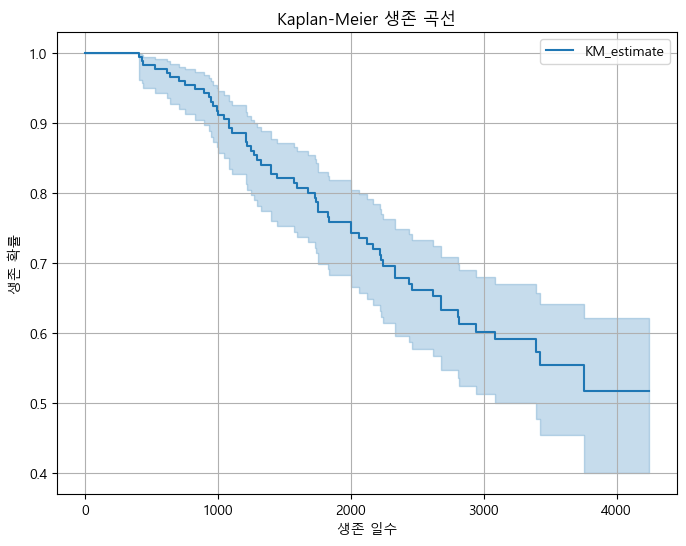

In [112]:
from lifelines import KaplanMeierFitter

# Kaplan-Meier Fitter 모델 생성
kmf = KaplanMeierFitter()

# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))
kmf.fit(durations=df['유지기간'], event_observed=df['suv'])
kmf.plot_survival_function()
plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

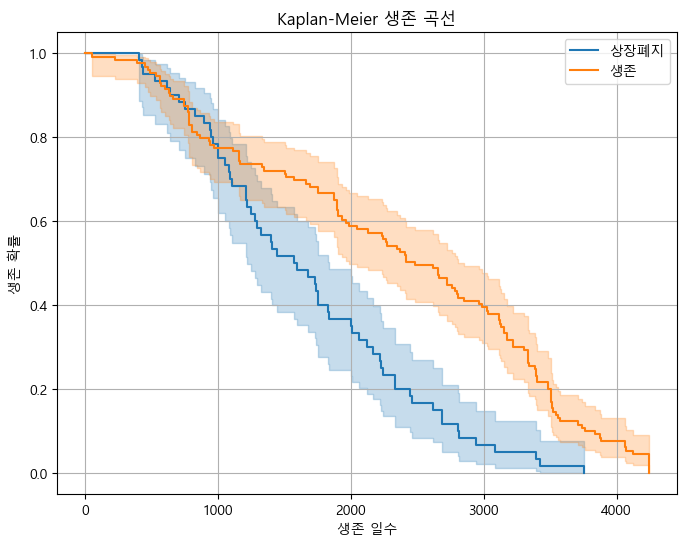

In [373]:
# 폐지된 그룹과 아닌 그룹의 케플란-마이어 결과

# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))

kmf.fit(durations=tmp_closed['유지기간'], label = '상장폐지')
kmf.plot_survival_function()

kmf.fit(durations=tmp_suv['유지기간'], label = '생존')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

## 각 연도별 적용

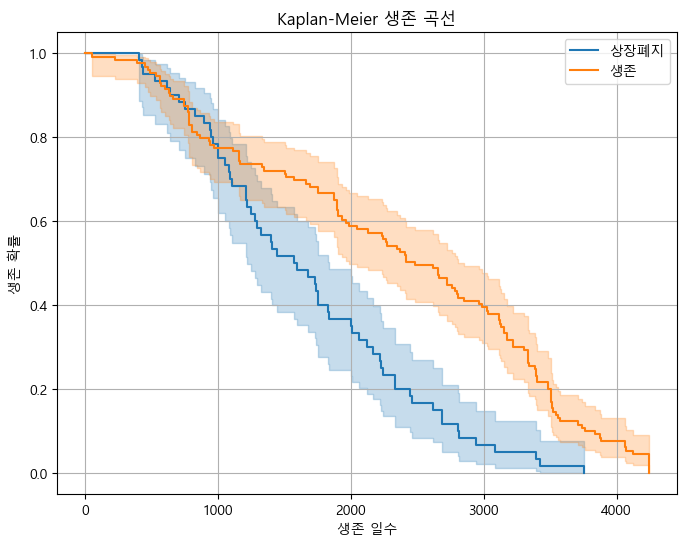

In [378]:
def divide_suv(df):

    tmp_closed = df[df['suv']==1] # 코넥스에서 폐지당한 애들 -> train
    tmp_suv =  df[df['suv']==0] # 코넥스에서 폐지 안 당한 애들 -> target

    return tmp_closed, tmp_suv

tmp_closed_2021, tmp_suv_2021 = divide_suv(df_2021)

# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))

kmf.fit(durations=tmp_closed_2021['유지기간'], label = '상장폐지')
kmf.plot_survival_function()

kmf.fit(durations=tmp_suv_2021['유지기간'], label = '생존')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

## Cox비례위험모델
- 시간에 따른 사건 발생률을 모델링.
- 공변량이 생존 시간에 미치는 영향을 평가하는데 유용함 -> 현재 칼럼이 너무 많음.
- 저변동성 칼럼 역시 모두 삭제되어야한다 (값의 대부분이 NaN인 칼럼들)

In [382]:
# Cox비례위험모델에는 숫자형, Bool형의 데이터만 가능 -> STR, Datetime모두 불가능하다.
# 또한, NaN 역시 존재하면 안 된다. 결측치는 우선적으로 0으로 처리한다.

def filter_numeric_columns(df):
    # 숫자형 칼럼만 필터링
    numeric_cols = df.select_dtypes(include=['number']).columns
    df_done = df[numeric_cols]
    
    # NaN 값을 0으로 대체
    df_done.fillna(0, inplace=True)

    return df_done

df_nums = filter_numeric_columns(df)
df_nums.head(3)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_71760\1455499443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_done.fillna(0, inplace=True)


,종목코드,유지기간,매출액_수익__2016,매출액_수익__2017,매출액_수익__2018,매출액_수익__2019,매출액_수익__2020,영업이익_2016,영업이익_2017,영업이익_2018,영업이익_2019,영업이익_2020,당기순이익_2016,당기순이익_2017,당기순이익_2018,당기순이익_2019,당기순이익_2020,매출액_수익__2021,영업이익_2021,당기순이익_2021,매출액_수익__2022,영업이익_2022,당기순이익_2022,매출액_수익__2023,영업이익_2023,당기순이익_2023,비유동자산_계__2020,비유동자산_계__2021,비유동자산_계__2022,비유동자산_계__2023,유형자산_계__2020,유형자산_계__2021,유형자산_계__2022,유형자산_계__2023,리스자산_2020,리스자산_2021,리스자산_2022,리스자산_2023,무형자산_계__2020,무형자산_계__2021,무형자산_계__2022,무형자산_계__2023,기타의무형자산_계__2020,기타의무형자산_계__2021,기타의무형자산_계__2022,기타의무형자산_계__2023,장기투자자산_2020,장기투자자산_2021,장기투자자산_2022,장기투자자산_2023,매출채권및기타채권_2020,매출채권및기타채권_2020_1,매출채권및기타채권_2021,매출채권및기타채권_2021_1,매출채권및기타채권_2022,매출채권및기타채권_2022_1,매출채권및기타채권_2023,매출채권및기타채권_2023_1,기타금융자산_2020,기타금융자산_2021,기타금융자산_2022,기타금융자산_2023,기타비금융자산_2020,기타비금융자산_2020_1,기타비금융자산_2021,기타비금융자산_2021_1,기타비금융자산_2022,기타비금융자산_2022_1,기타비금융자산_2023,기타비금융자산_2023_1,유동자산_계__2020,유동자산_계__2021,유동자산_계__2022,유동자산_계__2023,재고자산_계__2020,재고자산_계__2021,재고자산_계__2022,재고자산_계__2023,매출채권및기타채권_2020_2,매출채권및기타채권_2020_3,매출채권및기타채권_2021_2,매출채권및기타채권_2021_3,매출채권및기타채권_2022_2,매출채권및기타채권_2022_3,매출채권및기타채권_2023_2,매출채권및기타채권_2023_3,기타비금융자산_2020_2,기타비금융자산_2020_3,기타비금융자산_2021_2,기타비금융자산_2021_3,기타비금융자산_2022_2,기타비금융자산_2022_3,기타비금융자산_2023_2,기타비금융자산_2023_3,현금및현금성자산_2020,현금및현금성자산_2021,현금및현금성자산_2022,현금및현금성자산_2023,자산총계_2020,자산총계_2021,자산총계_2022,자산총계_2023,납입자본_2020,납입자본_2021,납입자본_2022,납입자본_2023,자본금_2020,자본금_2021,자본금_2022,자본금_2023,이익잉여금_2020,이익잉여금_2021,이익잉여금_2022,이익잉여금_2023,기타자본구성요소_2020,기타자본구성요소_2021,기타자본구성요소_2022,기타자본구성요소_2023,기타포괄손익누계액_2020,기타포괄손익누계액_2021,기타포괄손익누계액_2022,기타포괄손익누계액_2023,기타자본구성_2020,기타자본구성_2021,기타자본구성_2022,기타자본구성_2023,자본총계_2020,자본총계_2021,자본총계_2022,자본총계_2023,_평균발행주식수__2020,_평균발행주식수__2021,_평균발행주식수__2022,_평균발행주식수__2023,비유동부채_계__2020,비유동부채_계__2021,비유동부채_계__2022,비유동부채_계__2023,매입채무및기타채무_2020,매입채무및기타채무_2020_1,매입채무및기타채무_2021,매입채무및기타채무_2021_1,매입채무및기타채무_2022,매입채무및기타채무_2022_1,매입채무및기타채무_2023,매입채무및기타채무_2023_1,비유동차입부채_2020,비유동차입부채_2021,비유동차입부채_2022,비유동차입부채_2023,장기사채_계__2020,장기사채_계__2021,장기사채_계__2022,장기사채_계__2023,장기차입금_계__2020,장기차입금_계__2021,장기차입금_계__2022,장기차입금_계__2023,기타금융부채_2020,기타금융부채_2020_1,기타금융부채_2021,기타금융부채_2021_1,기타금융부채_2022,기타금융부채_2022_1,기타금융부채_2023,기타금융부채_2023_1,퇴직급여채무_2020,퇴직급여채무_2021,퇴직급여채무_2022,퇴직급여채무_2023,유동부채_계__2020,유동부채_계__2021,유동부채_계__2022,유동부채_계__2023,매입채무및기타채무_2020_2,매입채무및기타채무_2020_3,매입채무및기타채무_2021_2,매입채무및기타채무_2021_3,매입채무및기타채무_2022_2,매입채무및기타채무_2022_3,매입채무및기타채무_2023_2,매입채무및기타채무_2023_3,유동차입부채_2020,유동차입부채_2021,유동차입부채_2022,유동차입부채_2023,단기차입금_2020,단기차입금_2021,단기차입금_2022,단기차입금_2023,유동성장기부채_2020,유동성장기부채_2021,유동성장기부채_2022,유동성장기부채_2023,유동성사채_2020,유동성사채_2021,유동성사채_2022,유동성사채_2023,기타비금융부채_2020,기타비금융부채_2020_1,기타비금융부채_2021,기타비금융부채_2021_1,기타비금융부채_2022,기타비금융부채_2022_1,기타비금융부채_2023,기타비금융부채_2023_1,단기충당부채_2020,단기충당부채_2021,단기충당부채_2022,단기충당부채_2023,부채총계_2020,부채총계_2021,부채총계_2022,부채총계_2023,부채와자본총계_2020,부채와자본총계_2021,부채와자본총계_2022,부채와자본총계_2023,"매출채권_공사,영업미수__2020","매출채권_공사,영업미수__2021","매출채권_공사,영업미수__2022","매출채권_공사,영업미수__2023",유형자산_2020,유형자산_2021,유형자산_2022,유형자산_2023,매입채무_2020,매입채무_2021,매입채무_2022,매입채무_2023,유동성장기차입금_2020,유동성장기차입금_2021,유동성장기차입금_2022,유동성장기차입금_2023,기타유동성장기부채_2020,기타유동성장기부채_2021,기타유동성장기부채_2022,기타유동성장기부채_2023,기타유동부채_2020,기타유동부채_2021,기타유동부채_2022,기타유동부채_2023,기타비유동부채_2020,기타비유동부채_2021,기타비유동부채_2022,기타비유동부채_2023,단기투자자산_2020,단기투자자산_2021,단기투자자산_2022,단기투자자산_2023,장기충당부채_계__2020,장기충당부채_계__2021,장기충당부채_계__2022,장기충당부채_계__2023,기타금융부채_2020_2,기타금융부채_2020_3,기타금융부채_2021_2,기타금융부채_2021_3,기타금융부채_2022_2,기타금융부채_2022_3,기타금융부채_2023_2,기타금융부채_2023_3,건설중인자산_2020,건설중인자산_2021,건설중인자산_2022,건설중인자산_2023,기타비금융부채_2020_2,기타비금융부채_2020_3,기타비금융부채_2021_2,기타비금융부채_2021_3,기타비금융부채_2022_2,기타비금융부채_2022_3,기타비금융부채_2023_2,기타비금융부채_2023_3,시가총액_2020,상장주식수_2020,시가총액_2021,상장주식수_2021,시가총액_2022,상장주식수_2022,시가총액_2023,상장주식수_2023,운전자산_2020,운전자산_2021,운전자산_2022,운전자산_2023,운전자본_2020,운전자본_2021,운전자본_2022,운전자본_2023,X1_2020,X2_2020,X4_2020,X5_2020,q_2020,X1_2021,X2_2021,X4_2021,X5_2021,q_2021,X1_2022,X2_2022,X4_2022,X5_2022,q_2022,X1_2023,X2_2023,X4_2023,X5_2023,q_2023,X3_2020,X3_2021,X3_2022,X3_2023,suv
0,199870,825,65842922.0,40997

In [211]:
# 회계 지표만 남기기 -> df_nums에만 적용 가능

df_suv = df_nums[df_nums.columns[-25:].tolist() + df_nums.columns[:2].tolist()]
df_suv.drop(columns=[col for col in df_suv.columns if '2020' in col], inplace=True)  # '2020'년도 삭제

# 분석 시 의미 없었던 칼럼 삭제
df_suv.drop(columns=['종목코드', 'X4_2021', 'X4_2022', 'X4_2023', 'q_2021', 'q_2022', 'q_2023'], inplace=True)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_71760\3393382026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suv.drop(columns=[col for col in df_suv.columns if '2020' in col], inplace=True)  # '2020'년도 삭제


<lifelines.CoxPHFitter: fitted with 189 total observations, 129 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 189
number of events observed = 60
   partial log-likelihood = -228.09
         time fit was run = 2025-02-21 06:40:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1_2021   -2.92      0.05      2.74           -8.29            2.46                0.00               11.66
X2_2021   -1.44      0.24      1.42           -4.23            1.34                0.01                3.84
X5_2021    1.22      3.39      1.56           -1.84            4.28                0.16               72.19
X1_2022   -5.09      0.01      3.40          -11.76            1.57                0.00                4.80
X2_2022    1.82      6.15      1.29           -0.72            4.35                0.49               77.75
X5_2022   -0.81      0.44      1.37           -3.49            1.86                0.03                6.45
X1_2023    2.21      9.12      3.58           -4.81            9.23                0.01            10177.02
X2_2023   -0.38      0.68      0.78           -1.91            1.14                0.15                3.13
X5_2023   -4.47      0.01      1.10           -6.63           -2.30                0.00                0.10
X3_2021    0.27      1.30      3.27           -6.15            6.68                0.00              796.66
X3_2022   -1.30      0.27      2.96           -7.11            4.50                0.00               89.78
X3_2023    7.02   1118.06      3.76           -0.36           14.40                0.70            1.79e+06

           cmp to     z      p  -log2(p)
covariate                               
X1_2021      0.00 -1.06   0.29      1.80
X2_2021      0.00 -1.01   0.31      1.69
X5_2021      0.00  0.78   0.43      1.21
X1_2022      0.00 -1.50   0.13      2.90
X2_2022      0.00  1.40   0.16      2.64
X5_2022      0.00 -0.59   0.55      0.86
X1_2023      0.00  0.62   0.54      0.90
X2_2023      0.00 -0.49   0.62      0.69
X5_2023      0.00 -4.05 <0.005     14.23
X3_2021      0.00  0.08   0.94      0.10
X3_2022      0.00 -0.44   0.66      0.60
X3_2023      0.00  1.86   0.06      4.01
---
Concordance = 0.87
Partial AIC = 480.18
log-likelihood ratio test = 104.19 on 12 df
-log2(p) of ll-ratio test = 53.40

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


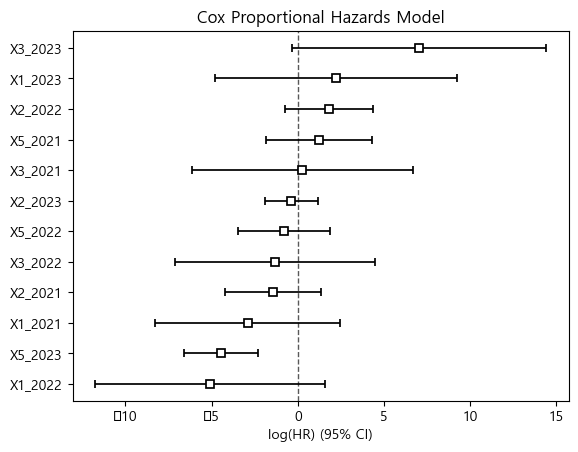

In [278]:
from lifelines import CoxPHFitter

# df_nums를 대상으로 분석을 진행한다.

# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
cph.fit(df_suv, duration_col='유지기간', event_col='suv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

## Cox비례모형 - 연도별로
- 2021, 2022, 2023 만을 분석 대상 시기로 삼는다.
- 매출액, 당기순이익, ... 만을 분석 대상으로 본다.

In [384]:
df_num_2021 = filter_numeric_columns(df_2021)
df_num_2022 = filter_numeric_columns(df_2022)
df_num_2023 = filter_numeric_columns(df_2023)

In [428]:
df_num_2021.columns

Index(['const', '매출액_수익__2021', '영업이익_2021', '당기순이익_2021', '비유동자산_계__2021',
       '유형자산_계__2021', '리스자산_2021', '무형자산_계__2021', '기타의무형자산_계__2021',
       '장기투자자산_2021', '매출채권및기타채권_2021', '매출채권및기타채권_2021_1', '기타금융자산_2021',
       '기타비금융자산_2021', '기타비금융자산_2021_1', '유동자산_계__2021', '재고자산_계__2021',
       '매출채권및기타채권_2021_2', '매출채권및기타채권_2021_3', '기타비금융자산_2021_2',
       '기타비금융자산_2021_3', '현금및현금성자산_2021', '자산총계_2021', '납입자본_2021', '자본금_2021',
       '이익잉여금_2021', '기타자본구성요소_2021', '기타포괄손익누계액_2021', '기타자본구성_2021',
       '자본총계_2021', '_평균발행주식수__2021', '비유동부채_계__2021', '매입채무및기타채무_2021',
       '매입채무및기타채무_2021_1', '비유동차입부채_2021', '장기사채_계__2021', '장기차입금_계__2021',
       '기타금융부채_2021', '기타금융부채_2021_1', '퇴직급여채무_2021', '유동부채_계__2021',
       '매입채무및기타채무_2021_2', '매입채무및기타채무_2021_3', '유동차입부채_2021', '단기차입금_2021',
       '유동성장기부채_2021', '유동성사채_2021', '기타비금융부채_2021', '기타비금융부채_2021_1',
       '단기충당부채_2021', '부채총계_2021', '부채와자본총계_2021', '매출채권_공사,영업미수__2021',
       '유형자산_2021', '매입채무_2021', '유동성장기차입금_2021', 

In [434]:
df_num_2021_1 = df_num_2021[['suv', '유지기간', 'X1_2021', 'X2_2021', 'X3_2021', 'X4_2021', 'X5_2021', 'q_2021']]
df_num_2022_1 = df_num_2022[['suv', '유지기간', 'X1_2022', 'X2_2022', 'X3_2022', 'X4_2022', 'X5_2022', 'q_2022']]
df_num_2023_1 = df_num_2023[['suv', '유지기간', 'X1_2023', 'X2_2023', 'X3_2023', 'X4_2023', 'X5_2023', 'q_2023']]

tmp = df_num_2021[['suv', '유지기간', '매출액_수익__2021', '영업이익_2021', '당기순이익_2021',
                   '시가총액_2021', '상장주식수_2021',
                    '운전자본_2021']]

Iteration 1: norm_delta = 9.67e-01, step_size = 0.9500, log_lik = -280.18105, newton_decrement = 2.41e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.68e-01, step_size = 0.9500, log_lik = -252.01904, newton_decrement = 5.98e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.43e-01, step_size = 0.9500, log_lik = -244.86305, newton_decrement = 2.43e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 9.92e-01, step_size = 0.9310, log_lik = -241.86591, newton_decrement = 1.05e+00, seconds_since_start = 0.0
Iteration 5: norm_delta = 6.88e-01, step_size = 0.9124, log_lik = -240.66050, newton_decrement = 2.12e-01, seconds_since_start = 0.0
Iteration 6: norm_delta = 2.24e-01, step_size = 0.8941, log_lik = -240.43385, newton_decrement = 1.59e-02, seconds_since_start = 0.0
Iteration 7: norm_delta = 1.17e-02, step_size = 1.0000, log_lik = -240.41747, newton_decrement = 4.02e-05, seconds_since_start = 0.0
Iteration 8: norm_delta = 2.94e-05, step_size = 1.0000, log_lik = -24

<lifelines.CoxPHFitter: fitted with 189 total observations, 129 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 189
number of events observed = 60
   partial log-likelihood = -240.42
         time fit was run = 2025-02-21 10:58:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1_2021   -3.13      0.04      1.40           -5.87           -0.40                0.00                0.67
X2_2021    0.35      1.42      0.36           -0.34            1.05                0.71                2.86
X3_2021   -0.29      0.75      1.81           -3.84            3.27                0.02               26.21
X4_2021   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
X5_2021   -1.34      0.26      0.37           -2.07           -0.62                0.13                0.54
q_2021    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
X1_2021      0.00 -2.25   0.02      5.34
X2_2021      0.00  0.99   0.32      1.64
X3_2021      0.00 -0.16   0.87      0.19
X4_2021      0.00 -1.00   0.32      1.67
X5_2021      0.00 -3.63 <0.005     11.78
q_2021       0.00 -1.56   0.12      3.08
---
Concordance = 0.82
Partial AIC = 492.83
log-likelihood ratio test = 79.53 on 6 df
-log2(p) of ll-ratio test = 47.67

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


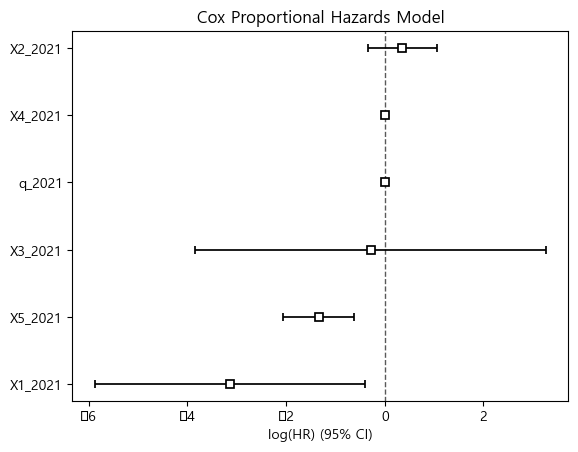

Iteration 1: norm_delta = 9.83e-01, step_size = 0.9500, log_lik = -280.18105, newton_decrement = 2.45e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.39e-01, step_size = 0.9500, log_lik = -251.85484, newton_decrement = 7.72e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.44e+00, step_size = 0.9500, log_lik = -242.16363, newton_decrement = 4.26e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.44e+00, step_size = 0.9310, log_lik = -237.03603, newton_decrement = 1.99e+00, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.03e+00, step_size = 0.9124, log_lik = -234.61437, newton_decrement = 9.24e-01, seconds_since_start = 0.0
Iteration 6: norm_delta = 1.13e+00, step_size = 0.8941, log_lik = -233.57737, newton_decrement = 1.51e-01, seconds_since_start = 0.0
Iteration 7: norm_delta = 2.57e-01, step_size = 0.8762, log_lik = -233.42221, newton_decrement = 6.93e-03, seconds_since_start = 0.0
Iteration 8: norm_delta = 5.07e-03, step_size = 1.0000, log_lik = -23

<lifelines.CoxPHFitter: fitted with 189 total observations, 129 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 189
number of events observed = 60
   partial log-likelihood = -233.42
         time fit was run = 2025-02-21 10:58:10 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1_2022   -4.92      0.01      1.44           -7.74           -2.10                0.00                0.12
X2_2022   -0.08      0.92      0.14           -0.36            0.20                0.70                1.22
X3_2022    0.41      1.50      0.96           -1.47            2.28                0.23                9.78
X4_2022   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
X5_2022   -1.35      0.26      0.33           -2.01           -0.70                0.13                0.50
q_2022    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
X1_2022      0.00 -3.42 <0.005     10.64
X2_2022      0.00 -0.57   0.57      0.82
X3_2022      0.00  0.43   0.67      0.58
X4_2022      0.00 -0.14   0.89      0.17
X5_2022      0.00 -4.05 <0.005     14.28
q_2022       0.00 -2.73   0.01      7.30
---
Concordance = 0.84
Partial AIC = 478.83
log-likelihood ratio test = 93.53 on 6 df
-log2(p) of ll-ratio test = 57.31

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


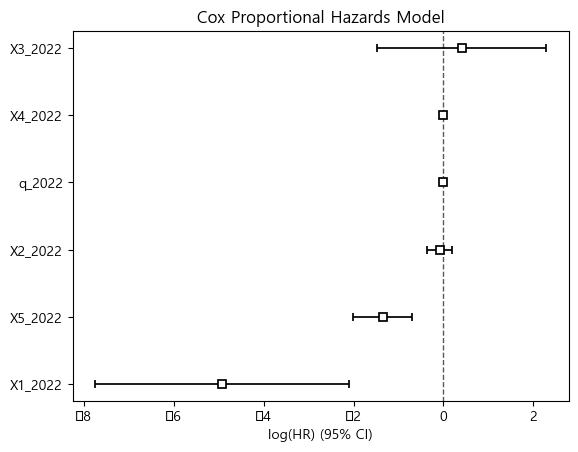

Iteration 1: norm_delta = 1.24e+00, step_size = 0.9500, log_lik = -280.18105, newton_decrement = 2.65e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.37e+00, step_size = 0.9500, log_lik = -248.10684, newton_decrement = 1.13e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.61e+00, step_size = 0.9500, log_lik = -233.81098, newton_decrement = 6.28e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.78e+00, step_size = 0.9310, log_lik = -226.34617, newton_decrement = 1.86e+00, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.50e+00, step_size = 0.9124, log_lik = -224.22450, newton_decrement = 3.91e-01, seconds_since_start = 0.0
Iteration 6: norm_delta = 4.82e-01, step_size = 0.8941, log_lik = -223.80401, newton_decrement = 3.54e-02, seconds_since_start = 0.0
Iteration 7: norm_delta = 3.67e-02, step_size = 1.0000, log_lik = -223.76686, newton_decrement = 2.52e-04, seconds_since_start = 0.0
Iteration 8: norm_delta = 3.22e-04, step_size = 1.0000, log_lik = -22

<lifelines.CoxPHFitter: fitted with 189 total observations, 129 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 189
number of events observed = 60
   partial log-likelihood = -223.77
         time fit was run = 2025-02-21 10:58:10 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1_2023   -2.87      0.06      2.80           -8.35            2.61                0.00               13.66
X2_2023    0.12      1.13      0.32           -0.50            0.75                0.61                2.11
X3_2023    8.12   3363.92      2.98            2.27           13.97                9.69            1.17e+06
X4_2023   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
X5_2023   -3.30      0.04      0.72           -4.71           -1.89                0.01                0.15
q_2023     0.00      1.00      0.00           -0.00            0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
X1_2023      0.00 -1.02   0.31      1.71
X2_2023      0.00  0.39   0.69      0.53
X3_2023      0.00  2.72   0.01      7.26
X4_2023      0.00 -2.28   0.02      5.46
X5_2023      0.00 -4.58 <0.005     17.73
q_2023       0.00  1.44   0.15      2.75
---
Concordance = 0.85
Partial AIC = 459.53
log-likelihood ratio test = 112.83 on 6 df
-log2(p) of ll-ratio test = 70.70

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


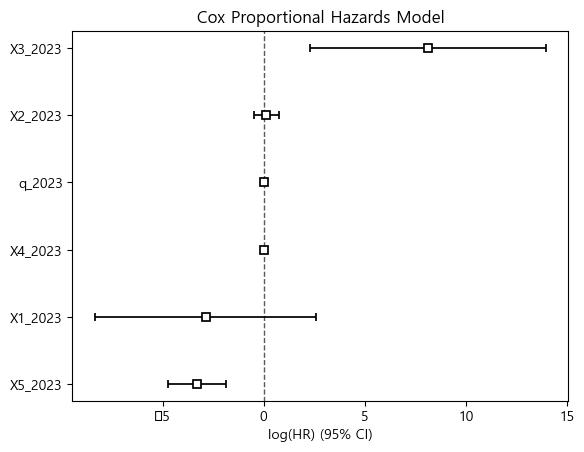

In [432]:
def cox(df):
    # Cox Proportional Hazards 모델 생성
    cph = CoxPHFitter()

    # 모델 학습 (하이퍼파라미터 조정)
    cph.fit(df, duration_col='유지기간', event_col='suv', show_progress=True)

    # 모델 요약 출력
    cph.print_summary()

    # 생존 곡선 시각화
    cph.plot()
    plt.title("Cox Proportional Hazards Model")
    plt.show()

cox(df_num_2021_1)
cox(df_num_2022_1)
cox(df_num_2023_1)

# 생존분석_RandomSurvivalTree 사용
- scikit-survival 패키지에서 제공한다.
- 데이터는 df_nums기준
- 생존 일수를 예측 및 점수화


In [279]:
df_nums.head(2)

,종목코드,유지기간,매출액_수익__2016,매출액_수익__2017,매출액_수익__2018,매출액_수익__2019,매출액_수익__2020,영업이익_2016,영업이익_2017,영업이익_2018,영업이익_2019,영업이익_2020,당기순이익_2016,당기순이익_2017,당기순이익_2018,당기순이익_2019,당기순이익_2020,매출액_수익__2021,영업이익_2021,당기순이익_2021,매출액_수익__2022,영업이익_2022,당기순이익_2022,매출액_수익__2023,영업이익_2023,당기순이익_2023,비유동자산_계__2020,비유동자산_계__2021,비유동자산_계__2022,비유동자산_계__2023,유형자산_계__2020,유형자산_계__2021,유형자산_계__2022,유형자산_계__2023,리스자산_2020,리스자산_2021,리스자산_2022,리스자산_2023,무형자산_계__2020,무형자산_계__2021,무형자산_계__2022,무형자산_계__2023,기타의무형자산_계__2020,기타의무형자산_계__2021,기타의무형자산_계__2022,기타의무형자산_계__2023,장기투자자산_2020,장기투자자산_2021,장기투자자산_2022,장기투자자산_2023,매출채권및기타채권_2020,매출채권및기타채권_2020_1,매출채권및기타채권_2021,매출채권및기타채권_2021_1,매출채권및기타채권_2022,매출채권및기타채권_2022_1,매출채권및기타채권_2023,매출채권및기타채권_2023_1,기타금융자산_2020,기타금융자산_2021,기타금융자산_2022,기타금융자산_2023,기타비금융자산_2020,기타비금융자산_2020_1,기타비금융자산_2021,기타비금융자산_2021_1,기타비금융자산_2022,기타비금융자산_2022_1,기타비금융자산_2023,기타비금융자산_2023_1,유동자산_계__2020,유동자산_계__2021,유동자산_계__2022,유동자산_계__2023,재고자산_계__2020,재고자산_계__2021,재고자산_계__2022,재고자산_계__2023,매출채권및기타채권_2020_2,매출채권및기타채권_2020_3,매출채권및기타채권_2021_2,매출채권및기타채권_2021_3,매출채권및기타채권_2022_2,매출채권및기타채권_2022_3,매출채권및기타채권_2023_2,매출채권및기타채권_2023_3,기타비금융자산_2020_2,기타비금융자산_2020_3,기타비금융자산_2021_2,기타비금융자산_2021_3,기타비금융자산_2022_2,기타비금융자산_2022_3,기타비금융자산_2023_2,기타비금융자산_2023_3,현금및현금성자산_2020,현금및현금성자산_2021,현금및현금성자산_2022,현금및현금성자산_2023,자산총계_2020,자산총계_2021,자산총계_2022,자산총계_2023,납입자본_2020,납입자본_2021,납입자본_2022,납입자본_2023,자본금_2020,자본금_2021,자본금_2022,자본금_2023,이익잉여금_2020,이익잉여금_2021,이익잉여금_2022,이익잉여금_2023,기타자본구성요소_2020,기타자본구성요소_2021,기타자본구성요소_2022,기타자본구성요소_2023,기타포괄손익누계액_2020,기타포괄손익누계액_2021,기타포괄손익누계액_2022,기타포괄손익누계액_2023,기타자본구성_2020,기타자본구성_2021,기타자본구성_2022,기타자본구성_2023,자본총계_2020,자본총계_2021,자본총계_2022,자본총계_2023,_평균발행주식수__2020,_평균발행주식수__2021,_평균발행주식수__2022,_평균발행주식수__2023,비유동부채_계__2020,비유동부채_계__2021,비유동부채_계__2022,비유동부채_계__2023,매입채무및기타채무_2020,매입채무및기타채무_2020_1,매입채무및기타채무_2021,매입채무및기타채무_2021_1,매입채무및기타채무_2022,매입채무및기타채무_2022_1,매입채무및기타채무_2023,매입채무및기타채무_2023_1,비유동차입부채_2020,비유동차입부채_2021,비유동차입부채_2022,비유동차입부채_2023,장기사채_계__2020,장기사채_계__2021,장기사채_계__2022,장기사채_계__2023,장기차입금_계__2020,장기차입금_계__2021,장기차입금_계__2022,장기차입금_계__2023,기타금융부채_2020,기타금융부채_2020_1,기타금융부채_2021,기타금융부채_2021_1,기타금융부채_2022,기타금융부채_2022_1,기타금융부채_2023,기타금융부채_2023_1,퇴직급여채무_2020,퇴직급여채무_2021,퇴직급여채무_2022,퇴직급여채무_2023,유동부채_계__2020,유동부채_계__2021,유동부채_계__2022,유동부채_계__2023,매입채무및기타채무_2020_2,매입채무및기타채무_2020_3,매입채무및기타채무_2021_2,매입채무및기타채무_2021_3,매입채무및기타채무_2022_2,매입채무및기타채무_2022_3,매입채무및기타채무_2023_2,매입채무및기타채무_2023_3,유동차입부채_2020,유동차입부채_2021,유동차입부채_2022,유동차입부채_2023,단기차입금_2020,단기차입금_2021,단기차입금_2022,단기차입금_2023,유동성장기부채_2020,유동성장기부채_2021,유동성장기부채_2022,유동성장기부채_2023,유동성사채_2020,유동성사채_2021,유동성사채_2022,유동성사채_2023,기타비금융부채_2020,기타비금융부채_2020_1,기타비금융부채_2021,기타비금융부채_2021_1,기타비금융부채_2022,기타비금융부채_2022_1,기타비금융부채_2023,기타비금융부채_2023_1,단기충당부채_2020,단기충당부채_2021,단기충당부채_2022,단기충당부채_2023,부채총계_2020,부채총계_2021,부채총계_2022,부채총계_2023,부채와자본총계_2020,부채와자본총계_2021,부채와자본총계_2022,부채와자본총계_2023,"매출채권_공사,영업미수__2020","매출채권_공사,영업미수__2021","매출채권_공사,영업미수__2022","매출채권_공사,영업미수__2023",유형자산_2020,유형자산_2021,유형자산_2022,유형자산_2023,매입채무_2020,매입채무_2021,매입채무_2022,매입채무_2023,유동성장기차입금_2020,유동성장기차입금_2021,유동성장기차입금_2022,유동성장기차입금_2023,기타유동성장기부채_2020,기타유동성장기부채_2021,기타유동성장기부채_2022,기타유동성장기부채_2023,기타유동부채_2020,기타유동부채_2021,기타유동부채_2022,기타유동부채_2023,기타비유동부채_2020,기타비유동부채_2021,기타비유동부채_2022,기타비유동부채_2023,단기투자자산_2020,단기투자자산_2021,단기투자자산_2022,단기투자자산_2023,장기충당부채_계__2020,장기충당부채_계__2021,장기충당부채_계__2022,장기충당부채_계__2023,기타금융부채_2020_2,기타금융부채_2020_3,기타금융부채_2021_2,기타금융부채_2021_3,기타금융부채_2022_2,기타금융부채_2022_3,기타금융부채_2023_2,기타금융부채_2023_3,건설중인자산_2020,건설중인자산_2021,건설중인자산_2022,건설중인자산_2023,기타비금융부채_2020_2,기타비금융부채_2020_3,기타비금융부채_2021_2,기타비금융부채_2021_3,기타비금융부채_2022_2,기타비금융부채_2022_3,기타비금융부채_2023_2,기타비금융부채_2023_3,시가총액_2020,상장주식수_2020,시가총액_2021,상장주식수_2021,시가총액_2022,상장주식수_2022,시가총액_2023,상장주식수_2023,운전자산_2020,운전자산_2021,운전자산_2022,운전자산_2023,운전자본_2020,운전자본_2021,운전자본_2022,운전자본_2023,X1_2020,X2_2020,X4_2020,X5_2020,q_2020,X1_2021,X2_2021,X4_2021,X5_2021,q_2021,X1_2022,X2_2022,X4_2022,X5_2022,q_2022,X1_2023,X2_2023,X4_2023,X5_2023,q_2023,X3_2020,X3_2021,X3_2022,X3_2023,suv
0,199870,825,65842922.0,40997

In [324]:
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.preprocessing import OneHotEncoder

# 생존 정보 변환 (event: 사망 여부, time: 생존 기간)
y = Surv.from_dataframe(event='suv',time='유지기간', data=df_nums)

# 그 외 함수들
X = df_nums.drop(columns=['유지기간', 'suv'])

# 훈련/테스트 데이터 분할 -> 굳이 필요하지 않은가?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

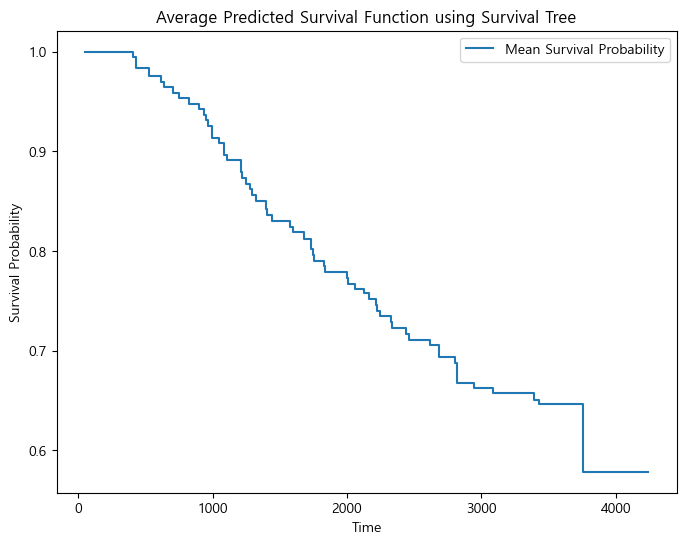

In [327]:
# 생존 트리 모델 학습
surv_tree = RandomSurvivalForest(n_estimators=100,
                                 max_depth=None,
                                 random_state=42)
surv_tree.fit(X,y)

# 전체 테스트 데이터에 대한 생존 확률 예측
survival_functions = surv_tree.predict_survival_function(X, return_array=False)

# 모든 샘플의 평균 생존 확률 계산
time_points = np.unique(np.hstack([fn.x for fn in survival_functions]))  # 모든 시간 지점 추출
mean_survival_probs = np.zeros_like(time_points, dtype=np.float64)

# 각 시간 지점에서 모든 샘플의 평균 생존 확률을 계산
for fn in survival_functions:
    mean_survival_probs += np.interp(time_points, fn.x, fn.y)  # 선형 보간
mean_survival_probs /= len(survival_functions)  # 평균 계산

# 5. 시각화
plt.figure(figsize=(8, 6))
plt.step(time_points, mean_survival_probs, where="post", label="Mean Survival Probability")

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Average Predicted Survival Function using Survival Tree")
plt.legend()
plt.show()

In [326]:
predictions = surv_tree.predict(X)

score = surv_tree.score(X, y)
print("ConCordance index", score)

ConCordance index 0.9386485313268702


### 생존 일수 예측

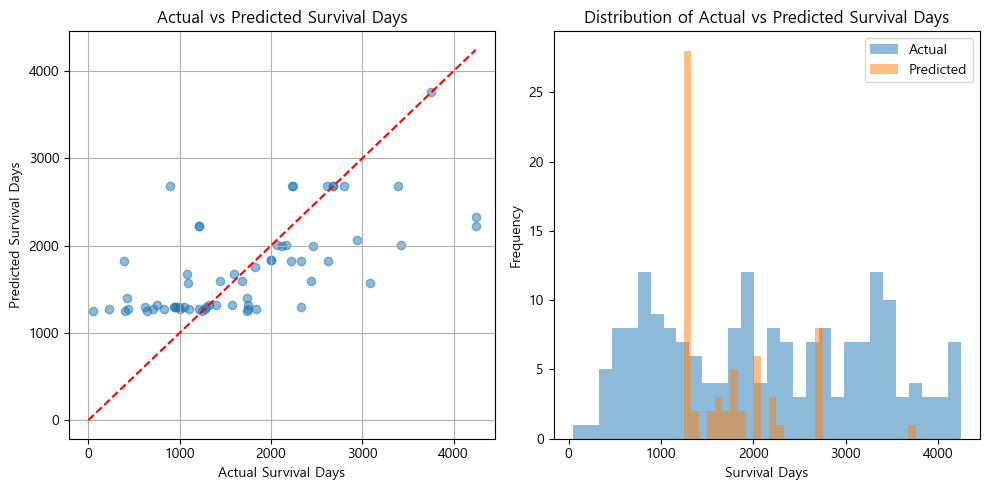

In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# 1. 데이터 준비 (df_nums: 기존 데이터)
y = Surv.from_dataframe(event='suv', time='유지기간', data=df_nums)
X = df_nums.drop(columns=['유지기간', 'suv', '종목코드'])

# 2. 훈련/테스트 데이터 분할
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 랜덤 생존 숲 모델 학습
rsf = RandomSurvivalForest(n_estimators=200, 
                           max_depth=10,
                           min_samples_split=10,
                           min_samples_leaf=5,
                           random_state=42)
rsf.fit(X, y)

# 4. 테스트 데이터에 대한 생존 확률 예측
survival_functions = rsf.predict_survival_function(X, return_array=False)

predicted_survival_days = []
for fn in survival_functions:
    if np.any(fn.y <= 0.5):  # 50% 이하 지점이 존재하는 경우
        median_index = np.where(fn.y <= 0.5)[0][0]
        predicted_days = fn.x[median_index]
    else:
        predicted_days = np.nan  # NaN 처리 (이후 평균으로 대체)
    
    predicted_survival_days.append(predicted_days)

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame({
    "실제 생존일수": y["유지기간"],  # 실제 생존 일수
    "예측 생존일수": predicted_survival_days  # 모델 예측값
})

# 6. 성능 평가 및 시각화
plt.figure(figsize=(10, 5))

# (1) 실제 vs. 예측 생존일수 산점도
plt.subplot(1, 2, 1)
plt.scatter(results_df["실제 생존일수"], results_df["예측 생존일수"], alpha=0.5)
plt.plot([0, max(results_df["실제 생존일수"])], [0, max(results_df["실제 생존일수"])], 'r--')  # 대각선 기준선
plt.xlabel("Actual Survival Days")
plt.ylabel("Predicted Survival Days")
plt.title("Actual vs Predicted Survival Days")
plt.grid()

# (2) 히스토그램 비교
plt.subplot(1, 2, 2)
plt.hist(results_df["실제 생존일수"], bins=30, alpha=0.5, label="Actual")
plt.hist(results_df["예측 생존일수"], bins=30, alpha=0.5, label="Predicted")
plt.xlabel("Survival Days")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs Predicted Survival Days")
plt.legend()

plt.tight_layout()
plt.show()


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


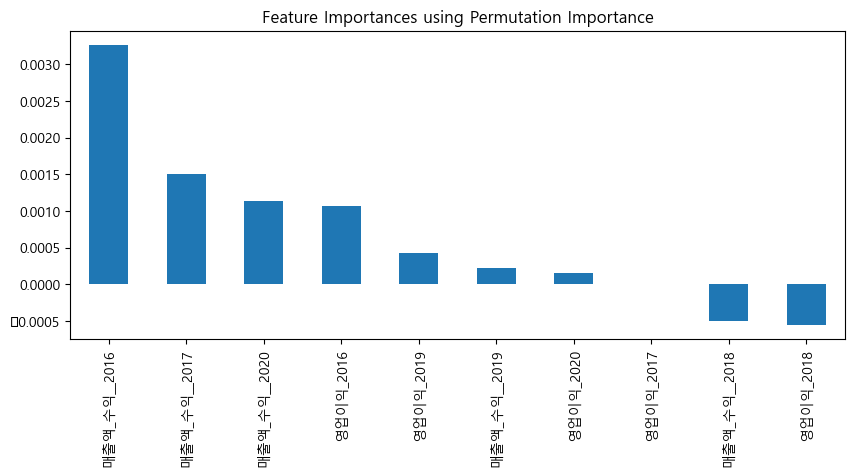

In [350]:
# 필요한 라이브러리 임포트
from sklearn.inspection import permutation_importance

# Permutation Importance 계산
result = permutation_importance(rsf, X, y, n_repeats=10, random_state=42)

# 중요도 결과를 데이터프레임으로 변환
importances = pd.Series(result.importances_mean, index=X.columns)
importances_10 = importances.head(10)
# 중요도 시각화
importances_10.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4))
plt.title("Feature Importances using Permutation Importance")
plt.show()

## 각 년도에 적용

# ML 사용
- 트리, XGBoost, Catboost, LightGBM 적용
- LGBM은 뭔가 문제가 있는 듯 함.

모델 정확도: 0.97


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 모델 정확도: 0.97
CatBoost 모델 정확도: 0.97


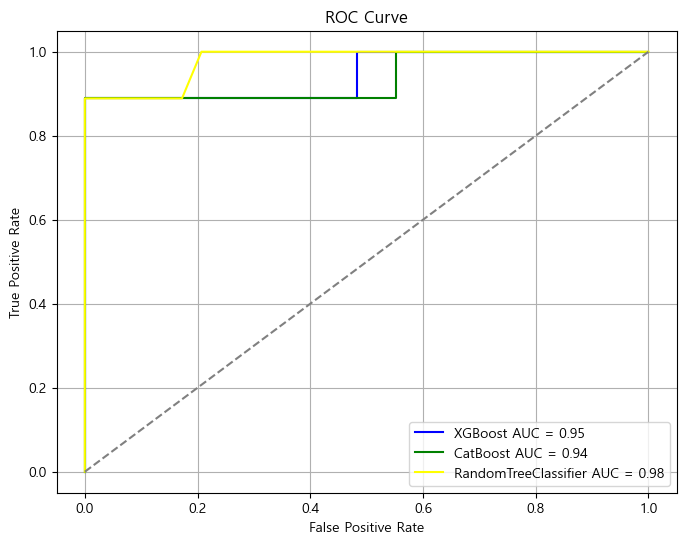

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

# 특성과 타겟 분리
X = df[df.select_dtypes(include=['number']).columns].drop(columns=['suv', '종목코드', '코넥스비고'])
y = df['suv']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 0. 랜덤 포레스트 분류 모델 생성 및 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도: {accuracy:.2f}")

# ROC 커브 및 AUC 계산
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 1. XGBoost 모델 생성 및 훈련
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 예측 수행
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost 모델 정확도: {accuracy_xgb:.2f}")

# ROC 커브 및 AUC 계산
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# 2. CatBoost 모델 생성 및 훈련
cat_model = CatBoostClassifier(silent=True)
cat_model.fit(X_train, y_train)

# 예측 수행
y_pred_cat = cat_model.predict(X_test)
y_pred_prob_cat = cat_model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy_cat = accuracy_score(y_test, y_pred_cat)
print(f"CatBoost 모델 정확도: {accuracy_cat:.2f}")

# ROC 커브 및 AUC 계산
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_prob_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# 3. LightGBM 모델 생성 및 훈련
'''
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# 예측 수행
y_pred_lgb = lgb_model.predict(X_test)
y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM 모델 정확도: {accuracy_lgb:.2f}")

# ROC 커브 및 AUC 계산
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_prob_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
'''

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'XGBoost AUC = {roc_auc_xgb:.2f}')
plt.plot(fpr_cat, tpr_cat, color='green', label=f'CatBoost AUC = {roc_auc_cat:.2f}')
plt.plot(fpr, tpr, color='yellow', label=f'RandomTreeClassifier AUC = {roc_auc:.2f}')
#plt.plot(fpr_lgb, tpr_lgb, color='red', label=f'LightGBM AUC = {roc_auc_lgb:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 생존분석 - 생존일수 예측
- 생존분석 라이브러리 활용